Task 1.0 example answer: **Name: *Jack Muir*, Email: *jmuir@caltech.edu* **

# Lab # 1 - Introduction to Observational Seismology in Python

Welcome to the first laboratory task of observational seismology. In this set of laboratories, we will learn the skills of modern observational seismology via the Python/Obspy workflow. Today, you will implement a basic seismological workflow; downloading, selecting, processing and plotting seismic waveforms. We will be skipping over some parts of the scientific python ecosystem in favor of jumping right into the seismology - these will be saved for the second lab session. 

## Using the Jupyter Notebook

Jupyter notebooks are a mixture of code cells and markdown text cells. Markdown is a light markup language that allows some flexibility in specifying textual effects (headers, italics etc.) without making the user choose different fonts / sizes etc - for reference, see https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet. Code blocks are executed using a Python kernel. Jupyter is a modal editor; it has a command mode, entered by the **esc** key, and an editing mode, entered by double clicking a cell. In the command mode, you can make a cell markdown by pressing **m**, and code by pressing **y**. To execute a cell, press **shift + enter**. You can create a new cell above by pressing **a**, and below by pressing **b**, whilst in command mode. Try to keep code cells short to keep the logic of your worksheet simple. There are many other keyboard shortcuts that you can find in the Jupyter documentation, and you can also use the menus to perform these tasks.

### Task 1.0

Create a cell above the notebook title containing your name and email address like so: **Name: *your-name* Email: *your-email* **

*note here - hopefully students realize that they can double click on this cell to edit it and then just copy the formatting that they see here*

## Importing Obspy

In the Python ecosystem, most interesting pieces of code are kept in modules that must be imported. By a quirk of the Obspy module, we have to import different submodules seperately - see below:

In [10]:
#A fdsn client allow us to connect with web services for obtaining data
from obspy.clients.fdsn import Client
#The UTCDateTime module specifies times in a consistent fashion - useful for specifying dates precisely 
from obspy import UTCDateTime
#we can add a "keyword argument" like "timeout" below to certain functions - keyword arguments allow Python functions 
#support variable numbers of arguments easily; once the keyword arguments start, their order doesn't matter
#we create a new client connected to the IRIS webservice, and increase the timeout value from its default 120s because
#2 minutes is often not enough to download all the data we want. 
iris_client = Client("IRIS", timeout=600)

## Searching for Events

One of the first things we are often intested in is the location and magnitude of an event. Whilst deriving these from seismograms is nontrivial, for historical events we can often fetch them from a catalogue. Lets look at a recent large earthquake in the Americas, the **2010 Maule earthquake**. 

In [23]:
#we use a UTCDateTime object to set the starting time of our search
st = UTCDateTime("2010-02-27T00:00:00Z")
#we can add a time offset in seconds to get the end time of the search
et = st + 24*3600
#or equivalently just use another UTCDateTime object
et = UTCDateTime("2010-02-28T00:00:00Z")
#we can then use the fdsn client to download an event catalogue, 
#specifying a large minimum magnitude to restrict the results
maule_catalogue = iris_client.get_events(starttime=st, endtime=et, minmagnitude=8)

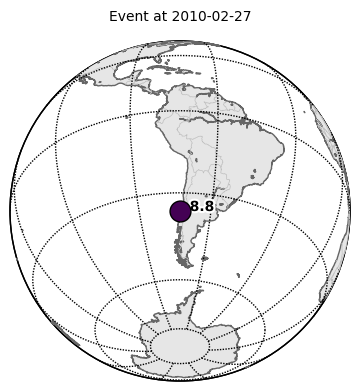

1 Event(s) in Catalog:
2010-02-27T06:34:13.330000Z | -36.148,  -72.933 | 8.8 MW


In [24]:
#we can let obspy automatically plot the results in a nice way - the orthographic "ortho" projection shows the location
#in a continental context. 
maule_catalogue.plot(projection='ortho')
#we can print the catalogue like so (obspy automatically formats it for us)
print(maule_catalogue)

### Task 1.1
Lets put the 2010 Maule earthquake in context. Make a plot of all > 6.5 magnitude earthquakes in South America between the latitudes of 30°S and 0°S, and longitudes of 85°W and 30°W, from 1975 to the beginning of 2017. Make the projection local & turn the magnitude label off so that you can see the spatial variation clearly. 
##### Questions:
 - What spatial features do you see in the data? 
 - From your knowledge of plate tectonics, what are the likely causes of these features?
 - What sort of earthquake was Maule likely to be?

#### *Hint*: 
You should look at the Obspy documentation to observe how to restrict the spatial range of your search appropriately, and to turn the magnitude plotting off. The url for the catalogue search is https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html
and for the catalogue plotting
https://docs.obspy.org/packages/autogen/obspy.core.event.catalog.Catalog.plot.html#obspy.core.event.catalog.Catalog.plot

#### Your Code: 

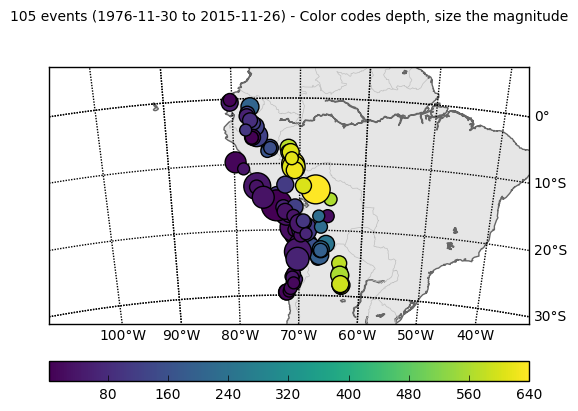

In [25]:
# Start your code here: 

#A possible acceptible answer
st = UTCDateTime("1975-01-01T00:00:00Z")
et = UTCDateTime("2017-01-01T00:00:00Z")

big_catalogue = client.get_events(starttime=st, 
                                  endtime=et, 
                                  minmagnitude=6.5,
                                  minlongitude=-85,
                                  maxlongitude=-30,
                                  minlatitude=-30,
                                  maxlatitude=0)

big_catalogue.plot(projection='local', label=None);

#### Your Answer to the questions:

##### Example good answer:
The earthquakes are concentrated on the western coast of South America. Furthermore, we see that the earthquakes generally increase in depth away from the coastline. We know that the Atlantic coast of South America is a passive continental margin, which explains the lack of large seismicity on the East coast. Additionally, we know that the Nazca plate subducts beneath the South American plate on the Pacific Coast; the deepening seismicity tracks the subducting slab as it penetrates into the mantle. Given the tectonic setting, Maule was likely a subduction associated thrust earthquake.

## Downloading & Processing Waveforms

Once we have identified an event of interest, we would naturally like some seismograms. Using the fdsn webservice through our IRIS client, we can download the data pertaining to our event. 

In [31]:
#Our catalogue possibly contains multiple events, each with possibly multiple origin solutions. 
#Since we know our catalogue only has one event it must occupy index 0, and likewise we are interested in the
#first origin solution. So we can get the event origin time by
evt_st = maule_catalogue[0].origins[0].time
#Obtaining seismograms is similar to getting the catalogue; we specify the seismic network/station/location/channel, 
#and start/end times. In this case, we are interested in CI.USC..BH(ENZ) channels - that is, the Southern California
#Seismic Network (CI) permanent station at the University of Southern California (USC). 
#We don't care about the "location" parameter as we know a priori that CI network stations don't have them, and
#we want broadband high gain (BH) for all 3 components (we use the * wildcard to do this - alternatively 
#we could manually write BHZ,BHN,BHE)

seismograms = iris_client.get_waveforms(network = "CI", 
                                        station = "USC", 
                                        location = "", 
                                        channel = "BH*", 
                                        starttime = evt_st, 
                                        endtime = evt_st+3600)   

Lets plot the data to see what it looks like

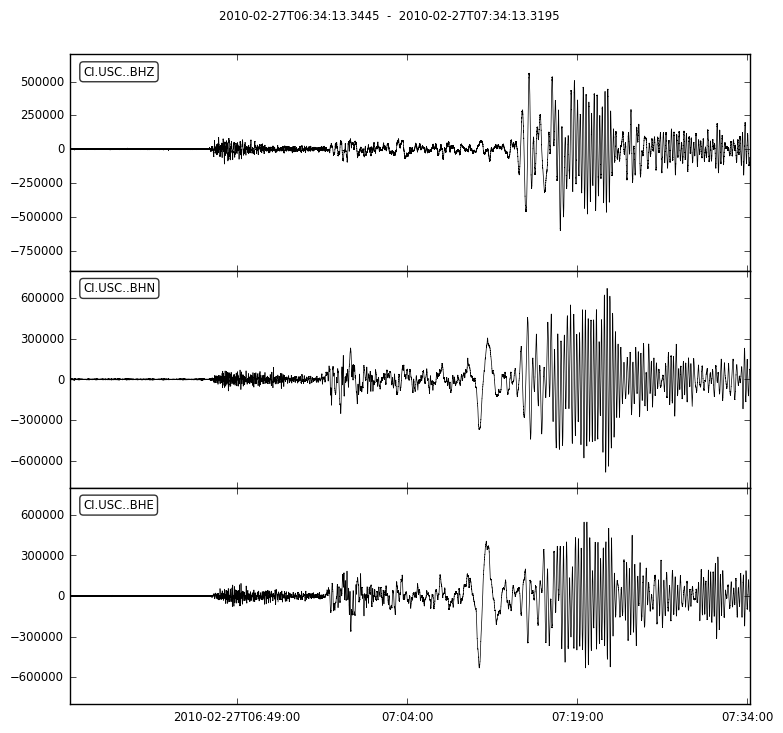

In [35]:
#If the data is very complex, it can be sometimes useful to make lines thinner so you can see finer details
seismograms.plot(linewidth=0.5)

### Task 1.2

Identify at what times the P-waves, S-waves, Love-waves and Rayleigh-waves arrive at USC. How do you know which is which? 

#### Your Answer:

##### Example good answer (of explanations):
- P-wave - arrives first
- S-wave - arrives second; lower frequency
- Love-wave - arrives third, very low frequency / not seen on vertical component
- Rayleigh-wave - arrives last, can see dispersion with low-frequency arriving first and frequency increasing with time. 

We can easily make plots of the seismograms at different frequencies by filtering them. To facilitate working with large datasets, Obspy does most of its processing in-place (this saves memory); however, we want to do lots of things with the data and only have a small dataset, so we should be careful to copy the data before operating on it. **If you accidentally process the original data, you must re-download it!** Let's look at the high frequency component.

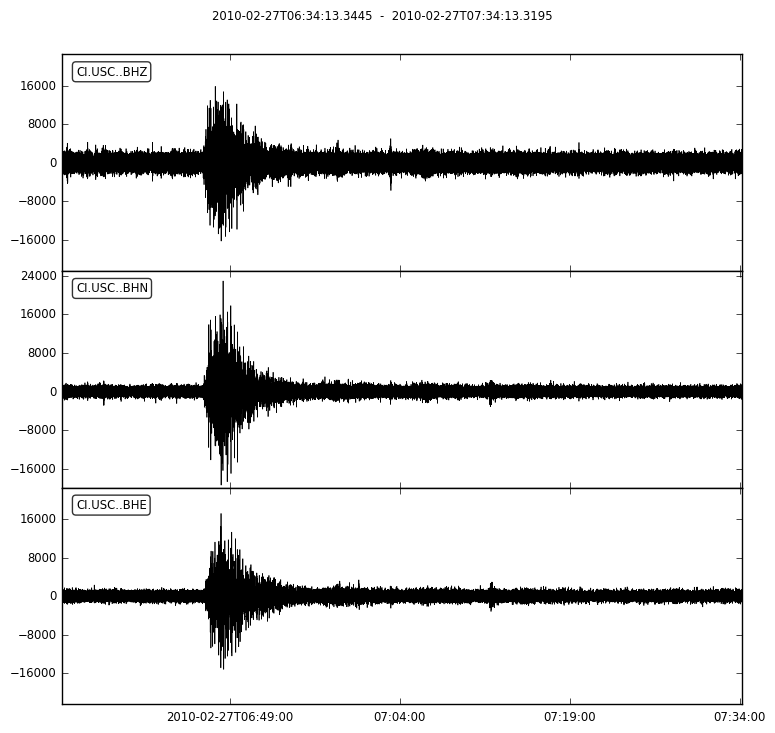

In [47]:
#Basically everything in Python is an object on which you can call methods; since these generally
#also return objects, we can call methods on those etc, allowing us to chain together operations like
#copying and filtering as shown below:
hf_seismograms = seismograms.copy().filter('bandpass', freqmin=0.5, freqmax=10)
hf_seismograms.plot(linewidth=0.5)

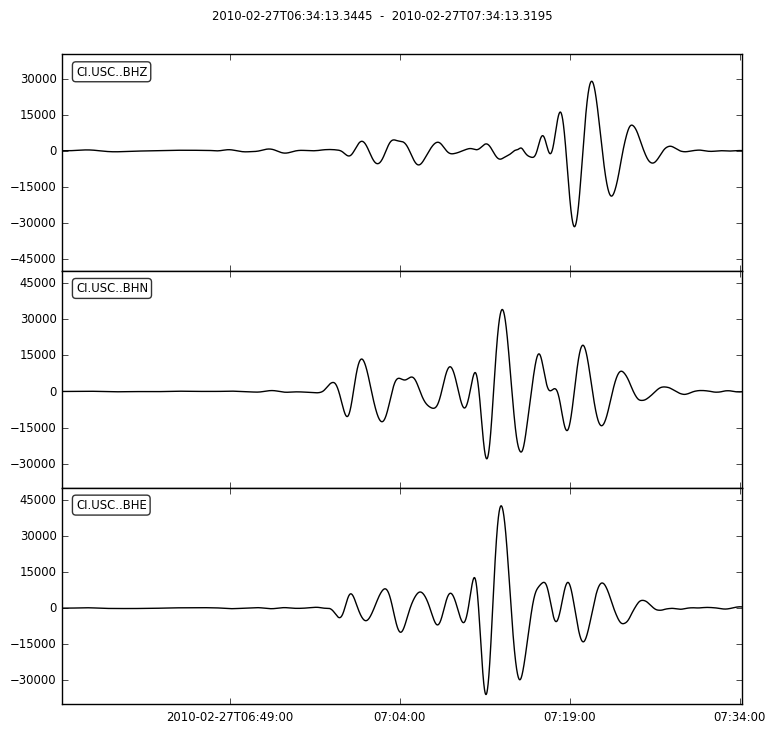

In [55]:
seismograms.copy().filter('bandpass', freqmin=0.001, freqmax=0.005).plot()